In [1]:
%pylab inline

import os
import itertools as it
from scipy.ndimage.filters import gaussian_filter
from string import replace

from tools.stats import err, binner

from styles.paper import *
from styles.colors import *
from styles.labels import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
#load model grid
class DynbasOutput():
    def __init__(self, filename):
        self.filename = filename
        self.file = open(filename, "r")
        
        self.file.readline()
        self.file.readline()

        self.age_grid = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        self.met_grid = array(map(eval, self.file.readline()[:-1].split("=")[1].split()[:-1]))
        self.ext_grid = array(map(eval, self.file.readline()[:-1].split("=")[1].split()[:-1]))
        
        self.file.readline()
        self.file.readline()
        self.file.readline()
        self.file.readline()
        
        self.age_1d = array([eval(self.file.readline()[:-1].split("=")[1])])
        self.age_2d = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        self.age_3d = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        
        self.met_1d = array([eval(self.file.readline()[:-1].split("=")[1])])
        self.met_2d = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        self.met_3d = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        
        self.mas_1d = array([eval(self.file.readline()[:-1].split("=")[1])])
        self.mas_2d = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        self.mas_3d = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        
        self.file.readline()
        self.file.readline()
        self.file.readline()
        self.file.readline()
        
        self.mass = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        self.mwla = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        self.lwla = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        self.mwlz = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        self.lwlz = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        self.extv = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        self.chis = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
    def get_grid(self):
        return self.age_grid, self.met_grid, self.ext_grid
    def get_properties(self):
        return self.mass, self.mwla, self.lwla, self.mwlz, self.lwlz, self.extv
    def get_best_properties(self):
        i = argmin(self.chis)
        return self.mass[i], self.mwla[i], self.lwla[i], self.mwlz[i], self.lwlz[i], self.extv[i]
    def get_model(self):
        return (self.mas_1d, self.mas_2d, self.mas_3d), (self.age_1d, self.age_2d, self.age_3d), (self.met_1d, self.met_2d, self.met_3d), self.extv
    def get_best_model(self):
        i = argmin(self.chis)
        return (self.mas_1d, self.mas_2d, self.mas_3d)[i], (self.age_1d, self.age_2d, self.age_3d)[i], (self.met_1d, self.met_2d, self.met_3d)[i], array([self.extv[i]])
    def compute_expected_error(self):
        mas, age, met, ext = self.get_best_model()
        
        model_ingredients = age, met, ext
        model_grids = self.get_grid()
                
        errors = []
        for j in xrange(len(model_grids)):
            error = []
            for k in xrange(len(model_ingredients[j])):
                i = argmin(abs(model_ingredients[j][k]-model_grids[j]))
                
                if i==0:
                    error.append(model_grids[j][i+1]-model_grids[j][i])
                elif i==model_grids[j].size-1:
                    error.append(model_grids[j][i]-model_grids[j][i-1])
                else:
                    error.append((model_grids[j][i+1]-model_grids[j][i-1])*0.5)

            errors.append(error)
            
        self.age_error, self.met_error, self.ext_error = array(errors[0]), array(errors[1]), array(errors[2])
        return self.age_error, self.met_error, self.ext_error

In [3]:
flist = sorted([os.path.join(root, file) for root, subs, files in os.walk("../inputs/proof_biasless/outs/jpas/") for file in files if file.startswith("dynbasfit_")])

errors = []
for file in flist:
    test = DynbasOutput(file)
    error = test.compute_expected_error()[0]
    if error.size==3:
        errors.append(sqrt(sum((test.mas_3d/test.mas_3d.sum()*error/test.age_3d)**2)))
    elif error.size==2:
        errors.append(sqrt(sum((test.mas_2d/test.mas_2d.sum()*error/test.age_2d)**2)))
    else:
        errors.append(sqrt(sum((test.mas_1d/test.mas_1d.sum()*error/test.age_1d)**2)))

errors = array(errors)

In [4]:
#load outputs from S/N tests

ssag_tta = genfromtxt("../inputs/tta_cb13/ssag/set_catalog.txt", dtype=None, names=True)

mask_ws = ssag_tta["Av_lib"]<=1.5
working_set = ssag_tta["name"][mask_ws]

ssag_tta = ssag_tta[mask_ws]

lcolor = ssag_tta["u"]-ssag_tta["r"]
fields = [field.replace("lib", "mod") for field in ssag_tta.dtype.names if "_lib" in field]
kws = [field.rstrip("_mod") for field in fields]

pags = lcolor>2.22
sfgs = ~pags
algs = pags|sfgs

#high-S/N test (S/N=999.9 for all spectral resolutions)
# sdss_hsn = genfromtxt("../inputs/proof_biasless/outs/sdss/dynbas_output.log", dtype=None, names=True)[mask_ws]
# jpas_hsn = genfromtxt("../inputs/proof_biasless/outs/jpas/dynbas_output.log", dtype=None, names=True)[mask_ws]
# spec_hsn = genfromtxt("../inputs/proof_biasless/outs/spec/dynbas_output.log", dtype=None, names=True)[mask_ws]

In [5]:
sdss_list = sorted([os.path.join(root,file) for root, subs, files in os.walk("../inputs/proof_biasless/outs/sdss") for file in files if file.startswith("dynbasfit_")])
jpas_list = sorted([os.path.join(root,file) for root, subs, files in os.walk("../inputs/proof_biasless/outs/jpas") for file in files if file.startswith("dynbasfit_")])
spec_list = sorted([os.path.join(root,file) for root, subs, files in os.walk("../inputs/proof_biasless/outs/spec") for file in files if file.startswith("dynbasfit_")])

sdss_fixed_ext_list = sorted([os.path.join(root,file) for root, subs, files in os.walk("../inputs/proof_biasless/outs/sdss_fixed_ext") for file in files if file.startswith("dynbasfit_")])

sdss_1d = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)
sdss_2d = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)
sdss_3d = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)
jpas_1d = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)
jpas_2d = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)
jpas_3d = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)
spec_1d = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)
spec_2d = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)
spec_3d = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)
sdss_best = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)
jpas_best = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)
spec_best = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)

sdss_fixed_ext_1d = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)
sdss_fixed_ext_2d = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)
sdss_fixed_ext_3d = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)
sdss_fixed_ext_best = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)
kws_mod = "M_mod log_t_M_mod log_t_L_mod log_Z_M_mod log_Z_L_mod Av_mod".split()
for i in xrange(len(sdss_list)):
    sdss = DynbasOutput(sdss_list[i])
    jpas = DynbasOutput(jpas_list[i])
    spec = DynbasOutput(spec_list[i])
    
    sdss_fixed_ext = DynbasOutput(sdss_fixed_ext_list[i])
    
    sdss_props = sdss.get_properties()
    jpas_props = jpas.get_properties()
    spec_props = spec.get_properties()
    
    sdss_best_props = sdss.get_best_properties()
    jpas_best_props = jpas.get_best_properties()
    spec_best_props = spec.get_best_properties()
    
    sdss_fixed_ext_props = sdss_fixed_ext.get_properties()
    sdss_fixed_ext_best_props = sdss_fixed_ext.get_best_properties()
    for j in xrange(len(kws_mod)):
        sdss_1d[kws_mod[j]].append(sdss_props[j][0])
        sdss_2d[kws_mod[j]].append(sdss_props[j][1])
        sdss_3d[kws_mod[j]].append(sdss_props[j][2])
        
        jpas_1d[kws_mod[j]].append(jpas_props[j][0])
        jpas_2d[kws_mod[j]].append(jpas_props[j][1])
        jpas_3d[kws_mod[j]].append(jpas_props[j][2])
        
        spec_1d[kws_mod[j]].append(spec_props[j][0])
        spec_2d[kws_mod[j]].append(spec_props[j][1])
        spec_3d[kws_mod[j]].append(spec_props[j][2])
        
        sdss_best[kws_mod[j]].append(sdss_best_props[j])
        jpas_best[kws_mod[j]].append(jpas_best_props[j])
        spec_best[kws_mod[j]].append(spec_best_props[j])
        
        sdss_fixed_ext_1d[kws_mod[j]].append(sdss_fixed_ext_props[j][0])
        sdss_fixed_ext_2d[kws_mod[j]].append(sdss_fixed_ext_props[j][1])
        sdss_fixed_ext_3d[kws_mod[j]].append(sdss_fixed_ext_props[j][2])
        
        sdss_fixed_ext_best[kws_mod[j]].append(sdss_fixed_ext_best_props[j])

for j in xrange(len(kws_mod)):
    if j==0:
        sdss_1d[kws_mod[j]] = log10(array(sdss_1d[kws_mod[j]]))[mask_ws]
        sdss_2d[kws_mod[j]] = log10(array(sdss_2d[kws_mod[j]]))[mask_ws]
        sdss_3d[kws_mod[j]] = log10(array(sdss_3d[kws_mod[j]]))[mask_ws]

        jpas_1d[kws_mod[j]] = log10(array(jpas_1d[kws_mod[j]]))[mask_ws]
        jpas_2d[kws_mod[j]] = log10(array(jpas_2d[kws_mod[j]]))[mask_ws]
        jpas_3d[kws_mod[j]] = log10(array(jpas_3d[kws_mod[j]]))[mask_ws]

        spec_1d[kws_mod[j]] = log10(array(spec_1d[kws_mod[j]]))[mask_ws]
        spec_2d[kws_mod[j]] = log10(array(spec_2d[kws_mod[j]]))[mask_ws]
        spec_3d[kws_mod[j]] = log10(array(spec_3d[kws_mod[j]]))[mask_ws]
        
        sdss_best[kws_mod[j]] = log10(array(sdss_best[kws_mod[j]]))[mask_ws]
        jpas_best[kws_mod[j]] = log10(array(jpas_best[kws_mod[j]]))[mask_ws]
        spec_best[kws_mod[j]] = log10(array(spec_best[kws_mod[j]]))[mask_ws]
        
        sdss_fixed_ext_1d[kws_mod[j]] = log10(array(sdss_fixed_ext_1d[kws_mod[j]]))[mask_ws]
        sdss_fixed_ext_2d[kws_mod[j]] = log10(array(sdss_fixed_ext_2d[kws_mod[j]]))[mask_ws]
        sdss_fixed_ext_3d[kws_mod[j]] = log10(array(sdss_fixed_ext_3d[kws_mod[j]]))[mask_ws]
        
        sdss_fixed_ext_best[kws_mod[j]] = log10(array(sdss_fixed_ext_best[kws_mod[j]]))[mask_ws]
    else:
        sdss_1d[kws_mod[j]] = array(sdss_1d[kws_mod[j]])[mask_ws]
        sdss_2d[kws_mod[j]] = array(sdss_2d[kws_mod[j]])[mask_ws]
        sdss_3d[kws_mod[j]] = array(sdss_3d[kws_mod[j]])[mask_ws]

        jpas_1d[kws_mod[j]] = array(jpas_1d[kws_mod[j]])[mask_ws]
        jpas_2d[kws_mod[j]] = array(jpas_2d[kws_mod[j]])[mask_ws]
        jpas_3d[kws_mod[j]] = array(jpas_3d[kws_mod[j]])[mask_ws]

        spec_1d[kws_mod[j]] = array(spec_1d[kws_mod[j]])[mask_ws]
        spec_2d[kws_mod[j]] = array(spec_2d[kws_mod[j]])[mask_ws]
        spec_3d[kws_mod[j]] = array(spec_3d[kws_mod[j]])[mask_ws]
        
        sdss_best[kws_mod[j]] = array(sdss_best[kws_mod[j]])[mask_ws]
        jpas_best[kws_mod[j]] = array(jpas_best[kws_mod[j]])[mask_ws]
        spec_best[kws_mod[j]] = array(spec_best[kws_mod[j]])[mask_ws]
        
        sdss_fixed_ext_1d[kws_mod[j]] = array(sdss_fixed_ext_1d[kws_mod[j]])[mask_ws]
        sdss_fixed_ext_2d[kws_mod[j]] = array(sdss_fixed_ext_2d[kws_mod[j]])[mask_ws]
        sdss_fixed_ext_3d[kws_mod[j]] = array(sdss_fixed_ext_3d[kws_mod[j]])[mask_ws]
        
        sdss_fixed_ext_best[kws_mod[j]] = array(sdss_fixed_ext_best[kws_mod[j]])[mask_ws]


In [6]:
ssag_tta["M_lib"] = log10(ssag_tta["M_lib"])

#compute residuals and discrepancies
sdss_res_1d = dict(
    M=err(ssag_tta["M_lib"], sdss_1d["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], sdss_1d["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], sdss_1d["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], sdss_1d["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], sdss_1d["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], sdss_1d["Av_mod"], False)
)
jpas_res_1d = dict(
    M=err(ssag_tta["M_lib"], jpas_1d["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], jpas_1d["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], jpas_1d["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], jpas_1d["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], jpas_1d["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], jpas_1d["Av_mod"], False)
)
spec_res_1d = dict(
    M=err(ssag_tta["M_lib"], spec_1d["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], spec_1d["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], spec_1d["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], spec_1d["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], spec_1d["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], spec_1d["Av_mod"], False)
)

sdss_res_2d = dict(
    M=err(ssag_tta["M_lib"], sdss_2d["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], sdss_2d["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], sdss_2d["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], sdss_2d["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], sdss_2d["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], sdss_2d["Av_mod"], False)
)
jpas_res_2d = dict(
    M=err(ssag_tta["M_lib"], jpas_2d["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], jpas_2d["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], jpas_2d["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], jpas_2d["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], jpas_2d["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], jpas_2d["Av_mod"], False)
)
spec_res_2d = dict(
    M=err(ssag_tta["M_lib"], spec_2d["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], spec_2d["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], spec_2d["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], spec_2d["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], spec_2d["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], spec_2d["Av_mod"], False)
)

sdss_res_3d = dict(
    M=err(ssag_tta["M_lib"], sdss_3d["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], sdss_3d["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], sdss_3d["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], sdss_3d["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], sdss_3d["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], sdss_3d["Av_mod"], False)
)
jpas_res_3d = dict(
    M=err(ssag_tta["M_lib"], jpas_3d["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], jpas_3d["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], jpas_3d["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], jpas_3d["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], jpas_3d["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], jpas_3d["Av_mod"], False)
)
spec_res_3d = dict(
    M=err(ssag_tta["M_lib"], spec_3d["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], spec_3d["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], spec_3d["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], spec_3d["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], spec_3d["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], spec_3d["Av_mod"], False)
)

sdss_res_best = dict(
    M=err(ssag_tta["M_lib"], sdss_best["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], sdss_best["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], sdss_best["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], sdss_best["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], sdss_best["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], sdss_best["Av_mod"], False)
)
jpas_res_best = dict(
    M=err(ssag_tta["M_lib"], jpas_best["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], jpas_best["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], jpas_best["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], jpas_best["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], jpas_best["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], jpas_best["Av_mod"], False)
)
spec_res_best = dict(
    M=err(ssag_tta["M_lib"], spec_best["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], spec_best["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], spec_best["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], spec_best["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], spec_best["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], spec_best["Av_mod"], False)
)

sdss_fixed_ext_res_1d = dict(
    M=err(ssag_tta["M_lib"], sdss_fixed_ext_1d["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], sdss_fixed_ext_1d["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], sdss_fixed_ext_1d["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], sdss_fixed_ext_1d["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], sdss_fixed_ext_1d["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], sdss_fixed_ext_1d["Av_mod"], False)
)
sdss_fixed_ext_res_2d = dict(
    M=err(ssag_tta["M_lib"], sdss_fixed_ext_2d["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], sdss_fixed_ext_2d["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], sdss_fixed_ext_2d["log_t_L_mod"], False),
    log_Z_M=None,
    log_Z_L=None,
    Av=None
)
sdss_fixed_ext_res_3d = dict(
    M=err(ssag_tta["M_lib"], sdss_fixed_ext_3d["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], sdss_fixed_ext_3d["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], sdss_fixed_ext_3d["log_t_L_mod"], False),
    log_Z_M=None,
    log_Z_L=None,
    Av=None
)

sdss_fixed_ext_res_best = dict(
    M=err(ssag_tta["M_lib"], sdss_fixed_ext_best["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], sdss_fixed_ext_best["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], sdss_fixed_ext_best["log_t_L_mod"], False),
    log_Z_M=None,
    log_Z_L=None,
    Av=None
)

In [7]:
def residual_table(residuals, masks, residual_labels, mask_labels, keywords):

    for i in xrange(len(keywords)):
        bias_a, pres_a = [], []
        bias_b, pres_b = [], []
        bias_c, pres_c = [], []
        for mask in masks:
            bias_a.append(median(residuals[0][keywords[i]][mask]))
            pres_a.append(diff(percentile(residuals[0][keywords[i]][mask], [16,84]))[0]*0.5)

            bias_b.append(median(residuals[1][keywords[i]][mask]))
            pres_b.append(diff(percentile(residuals[1][keywords[i]][mask], [16,84]))[0]*0.5)

            bias_c.append(median(residuals[2][keywords[i]][mask]))
            pres_c.append(diff(percentile(residuals[2][keywords[i]][mask], [16,84]))[0]*0.5)

        for j in xrange(len(masks)):
            if j==0:
                print r"\multirow{3}{*}{%s}   &%10s &%10.3f &%10.3f & &%10.3f &%10.3f & &%10.3f &%10.3f\\" %\
                (residual_labels[i], mask_labels[j], bias_a[j], pres_a[j], bias_b[j], pres_b[j], bias_c[j], pres_c[j])
            else:
                print r"                          &%10s &%10.3f &%10.3f & &%10.3f &%10.3f & &%10.3f &%10.3f\\" %\
                (mask_labels[j], bias_a[j], pres_a[j], bias_b[j], pres_b[j], bias_c[j], pres_c[j])
        print r"\hline"

def residuals_vs_prop(residuals, res_ids, keywords, res_lbs, compare=None, limits=((-0.2, 0.2),(1.3, 3.0)), colors=[samples["dark"],[samples["medium"],None]], nbins=15):
    xlm, ylm = limits

    fig, axs = subplots(len(residuals), len(keywords), figsize=(7,4), sharex=True, sharey=True)

    axs[0,0].set_xlim(xlm)
    axs[0,0].xaxis.set_major_locator(MaxNLocator(nbins=4, prune="both"))

    for i, j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
        x, y, e = binner(lcolor, residuals[i][keywords[j]], nbins, ylm, (median,lambda x: abs(percentile(x,[16,84])-median(x))))

        axs[i, j].axvline(ls="-.", color="w", lw=0.5)
        axs[i, j].axhline(2.22, ls="-.", color="w", lw=0.5)
        
        axs[i, j].plot(gaussian_filter(y,1.5), x, "-", color=colors[0], lw=1)
        axs[i, j].fill_betweenx(x, gaussian_filter(y-e[0],1.5), gaussian_filter(y+e[1],1.5), facecolor=colors[1][0], lw=0)

        if compare!=None:
            if compare[i]!=None:
                if compare[i][keywords[j]] is not None:
                    xc, yc, ec = binner(lcolor, compare[i][keywords[j]], nbins, ylm, (median,lambda x: abs(percentile(x,[16,84])-median(x))))

                    if colors[1][1]==None: colors[1][1] = samples["light"]
                    
                    axs[i, j].plot(gaussian_filter(yc,1.5), xc, "--", color=colors[0], lw=1)
                    axs[i, j].fill_betweenx(xc, gaussian_filter(yc-ec[0],1.5), gaussian_filter(yc+ec[1],1.5), facecolor=colors[1][1], lw=0, alpha=0.9)

        if axs[i,j].is_first_col():
            axs[i,j].set_ylabel(r"$u-r$")
            axs[i,j].text(0.05, 0.95, res_ids[i], size="x-small", ha="left", va="top", transform=axs[i,j].transAxes)
        if axs[i,j].is_last_row():
            axs[i,j].set_xlabel(res_lbs[keywords[j]])

    axs[1, 0].set_ylim(x[0], x[-1])

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.07, hspace=0.07)
    
    return fig

def degeneracies_plots(residuals, res_ids, planes=(("log_t_L", "log_Z_L"),("log_t_L", "M"),("log_t_L", "Av"),("log_t_M", "M")), thetas=(0.0,pi/2,pi,1.5*pi), colors=cm.spectral(linspace(0,1,2))):
    spec_deg_pa, jpas_deg_pa, sdss_deg_pa = [], [], []
    spec_deg_sf, jpas_deg_sf, sdss_deg_sf = [], [], []
    spec_deg_al, jpas_deg_al, sdss_deg_al = [], [], []
    for degeneracy in planes:
        x, y = degeneracy

        spec_deg_pa.append(abs(corrcoef(residuals[0][x][pags], residuals[0][y][pags])[0,1]))
        jpas_deg_pa.append(abs(corrcoef(residuals[1][x][pags], residuals[1][y][pags])[0,1]))
        sdss_deg_pa.append(abs(corrcoef(residuals[2][x][pags], residuals[2][y][pags])[0,1]))

        spec_deg_sf.append(abs(corrcoef(residuals[0][x][sfgs], residuals[0][y][sfgs])[0,1]))
        jpas_deg_sf.append(abs(corrcoef(residuals[1][x][sfgs], residuals[1][y][sfgs])[0,1]))
        sdss_deg_sf.append(abs(corrcoef(residuals[2][x][sfgs], residuals[2][y][sfgs])[0,1]))

        spec_deg_al.append(abs(corrcoef(residuals[0][x], residuals[0][y])[0,1]))
        jpas_deg_al.append(abs(corrcoef(residuals[1][x], residuals[1][y])[0,1]))
        sdss_deg_al.append(abs(corrcoef(residuals[2][x], residuals[2][y])[0,1]))

    degs_pa = [spec_deg_pa, jpas_deg_pa, sdss_deg_pa]
    degs_sf = [spec_deg_sf, jpas_deg_sf, sdss_deg_sf]
    degs_al = [spec_deg_al, jpas_deg_al, sdss_deg_al]

    fig = figure(figsize=(3.3, 5))

    template = r"$[{},{}]$"
    for j, lb in enumerate(res_ids):
        ax = fig.add_subplot(3, 1, j+1, projection="polar")
        ax.set_rlim(0, 1)
        ax.text(pi/4, 0.5, res_ids[j], fontsize="small")

        ax.set_rgrids(linspace(0.2,0.8,4), angle=-45)

        if j==0:
            deg_lbs = [r"" if i!=1 else template.format(Delta_int[x].strip("$"),Delta_int[y].strip("$")) for i,(x,y) in enumerate(planes)]
            l, t = ax.set_thetagrids(degrees(thetas), labels=deg_lbs)
        if j==1:
            deg_lbs = [r"" if i in [1,3] else template.format(Delta_int[x].strip("$"),Delta_int[y].strip("$")) for i,(x,y) in enumerate(planes)]
            l, t = ax.set_thetagrids(degrees(thetas), labels=deg_lbs)
        if j==2:
            deg_lbs = [r"" if i!=3 else template.format(Delta_int[x].strip("$"),Delta_int[y].strip("$")) for i,(x,y) in enumerate(planes)]
            l, t = ax.set_thetagrids(degrees(thetas), labels=deg_lbs)

        for text in t[::2]: text.set_rotation(90)

        ax.fill_between(thetas+thetas[0:1], degs_al[j]+degs_al[j][0:1], color=samples["light"], lw=0, label=algs_lb)
        ax.plot(thetas+thetas[0:1], degs_pa[j]+degs_pa[j][0:1], "-", lw=1.5, color=colors[0], label=pags_lb)
        ax.plot(thetas+thetas[0:1], degs_sf[j]+degs_sf[j][0:1], "-", lw=1.5, color=colors[1], label=sfgs_lb)

    ax.legend(loc=(-0.1,3.1), ncol=3)
    fig.tight_layout()
    fig.subplots_adjust(hspace=0)
    
    return fig

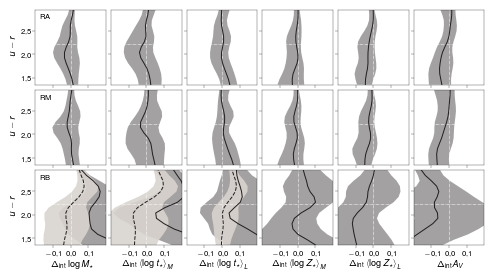

In [8]:
#fig = residuals_vs_prop((spec_res_1d, jpas_res_1d, sdss_res_1d), labels=(r"Spec.", r"J-PAS", r"$ugriz$"), keywords=kws, res_lbs=Delta_int)
#fig = residuals_vs_prop((spec_res_2d, jpas_res_2d, sdss_res_2d), labels=(r"Spec.", r"J-PAS", r"$ugriz$"), keywords=kws, res_lbs=Delta_int)
#fig = residuals_vs_prop((spec_res_3d, jpas_res_3d, sdss_res_3d), labels=(r"Spec.", r"J-PAS", r"$ugriz$"), keywords=kws, res_lbs=Delta_int)
fig = residuals_vs_prop((spec_res_best, jpas_res_best, sdss_res_best), (spec_lb, jpas_lb, sdss_lb), keywords=kws, res_lbs=Delta_int, compare=(None, None, sdss_fixed_ext_res_2d))
fig.savefig(os.path.expandvars("$HOME/Documents/Publications/PhD-thesis/figures/noiseless_residuals.pdf"))

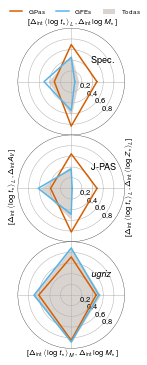

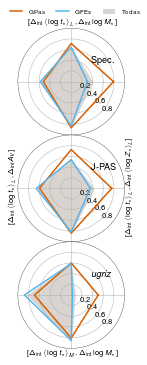

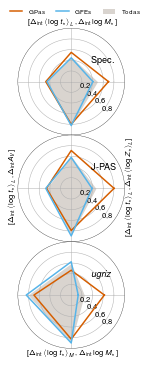

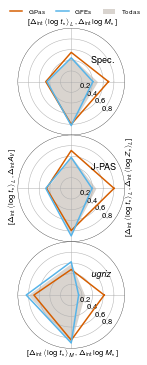

In [9]:
fig = degeneracies_plots((spec_res_1d,jpas_res_1d,sdss_res_1d), (r"Spec.", r"J-PAS", r"$ugriz$"), colors=(samples["hot"],samples["cold"]))
fig = degeneracies_plots((spec_res_2d,jpas_res_2d,sdss_res_2d), (r"Spec.", r"J-PAS", r"$ugriz$"), colors=(samples["hot"],samples["cold"]))
fig = degeneracies_plots((spec_res_3d,jpas_res_3d,sdss_res_3d), (r"Spec.", r"J-PAS", r"$ugriz$"), colors=(samples["hot"],samples["cold"]))
fig = degeneracies_plots((spec_res_best,jpas_res_best,sdss_res_best), (r"Spec.", r"J-PAS", r"$ugriz$"), colors=(samples["hot"],samples["cold"]))

In [10]:
residual_table([spec_res_1d,jpas_res_1d,sdss_res_1d], [sfgs,pags,algs], r"\dlogm \dmwla \dlwla \dmwlz \dlwlz \dextv".split(), [sfgs_lb,pags_lb,algs_lb], kws)
residual_table([spec_res_2d,jpas_res_2d,sdss_res_2d], [sfgs,pags,algs], r"\dlogm \dmwla \dlwla \dmwlz \dlwlz \dextv".split(), [sfgs_lb,pags_lb,algs_lb], kws)
residual_table([spec_res_3d,jpas_res_3d,sdss_res_3d], [sfgs,pags,algs], r"\dlogm \dmwla \dlwla \dmwlz \dlwlz \dextv".split(), [sfgs_lb,pags_lb,algs_lb], kws)
residual_table([spec_res_best,jpas_res_best,sdss_res_best], [sfgs,pags,algs], r"\dlogm \dmwla \dlwla \dmwlz \dlwlz \dextv".split(), [sfgs_lb,pags_lb,algs_lb], kws)

\multirow{3}{*}{\dlogm}   &      GFEs &    -0.123 &     0.150 & &    -0.149 &     0.166 & &    -0.280 &     0.377\\
                          &      GPas &    -0.049 &     0.147 & &    -0.051 &     0.137 & &    -0.033 &     0.158\\
                          &     Todas &    -0.110 &     0.160 & &    -0.126 &     0.166 & &    -0.203 &     0.253\\
\hline
\multirow{3}{*}{\dmwla}   &      GFEs &    -0.346 &     0.252 & &    -0.394 &     0.323 & &    -0.577 &     0.673\\
                          &      GPas &    -0.119 &     0.185 & &    -0.108 &     0.156 & &    -0.030 &     0.270\\
                          &     Todas &    -0.266 &     0.283 & &    -0.249 &     0.312 & &    -0.310 &     0.595\\
\hline
\multirow{3}{*}{\dlwla}   &      GFEs &     0.003 &     0.161 & &    -0.050 &     0.233 & &    -0.156 &     0.523\\
                          &      GPas &    -0.028 &     0.135 & &     0.002 &     0.134 & &     0.052 &     0.204\\
                          &     Todas &    -0.006 &     0.